# Setup

In [3]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [2]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update &> /dev/null


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip &> /dev/null

# Boost libraries
apt-get install libboost-all-dev &> /dev/null


In [3]:
!pip install vizdoom --quiet 
!pip install ray  --quiet
!pip install ray['rllib'] --quiet
!pip install Ipython --upgrade --quiet

     |████████████████████████████████| 15.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59.4 MB 100.8 MB/s 
     |████████████████████████████████| 8.8 MB 50.8 MB/s 
     |████████████████████████████████| 4.1 MB 70.3 MB/s 
     |████████████████████████████████| 468 kB 85.6 MB/s 
     |████████████████████████████████| 125 kB 5.2 MB/s 
     |████████████████████████████████| 626 kB 42.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2 MB 88.6 MB/s 
     |████████████████████████████████| 793 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 80.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

In [4]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [5]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import src.helper_fuctions as helper
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from fnmatch import fnmatch 
import numpy as np
sns.set()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Initialize Ray

In [7]:
ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")

Shutdown ray


2022-09-28 22:19:53,565	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# ICM 

In [8]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = True
config['in_evaluation'] = True

config["num_workers"] = 0 

config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}
#config["vf_clip_param"] = 400
icm_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

2022-09-28 22:19:55,843	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-28 22:19:55,846	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/icm/my_way_home_verySparse.wad
episode timeout: 2100
screen resolution: 320X240


2022-09-28 22:19:56,951	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-28 22:20:01,349	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [9]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/icm/my_way_home_verySparse.wad
episode timeout: 2100
screen resolution: 320X240


## ICM shortest Path

In [10]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward" 
chkpt_dir = "checkpoint_000" + str((800)) #str(best_chkpt+800)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000800'

In [11]:
icm_agent.restore(chkpt_pth)

2022-09-28 22:20:08,594	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000800
2022-09-28 22:20:08,596	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 60802.57106924057, '_episodes_total': 9009}


cumulative reward 448.0013427734375
total steps: 349
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/default/my_way_home.wad
Health Bonus locations: []
Armor location: [(1040.0, -352.0)]
Sector locations: [(160.0, 160.0, -256.0, -96.0), (160.0, 320.0, -96.0, -96.0), (320.0, 320.0, -96.0, -144.0), (320.0, 160.0, -256.0, -256.0), (320.0, 320.0, -208.0, -256.0), (544.0, 496.0, -256.0, -256.0), (544.0, 544.0, -96.0, -144.0), (384.0, 432.0, -96.0, -96.0), (384.0, 384.0, -256.0, -208.0), (384.0, 384.0, -144.0, -96.0), (496.0, 544.0, -96.0, -96.0), (432.0, 384.0, -256.0, -256.0), (544.0, 544.0, -208.0, -256.0), (544.0, 496.0, -32.0, -32.0), (544.0, 544.0, 128.0, 80.0), (384.0, 544.0, 128.0, 128.0), (384.0, 384.0, -32.0, 128.0), (544.0, 544.0, 16.0, -32.0), (432.0, 384.0, -32.0, -32.0), (608.0, 608.0, -256.0, -208.0), (768.0, 608.0, -256.0, -256.0), (768.0, 768.0, -96.0, 

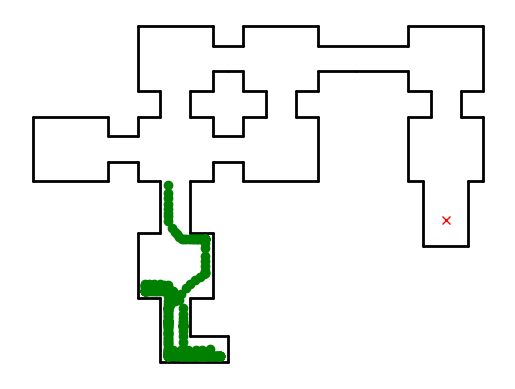

In [14]:
state = env.reset()
sum_reward = 0
n_step = 550
icm_path = [] 

for step in range(n_step):
    action = icm_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      icm_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "default/my_way_home.wad")
                                                       #"custom/test/dense_new_pattern_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, icm_path)


In [36]:
icm_path_1 = icm_path

In [38]:
icm_path_2 = icm_path

In [40]:
icm_path_3 = icm_path

# RE3

In [15]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass

In [16]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['explore'] = True 
config['in_evaluation'] = True
config["framework"] = "tf"
config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}
re3_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

(RolloutWorker pid=10996) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=10996) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/icm/my_way_home_verySparse.wad
(RolloutWorker pid=10996) episode timeout: 2100
(RolloutWorker pid=10996) screen resolution: 320X240
(RolloutWorker pid=10997) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=10997) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/icm/my_way_home_verySparse.wad
(RolloutWorker pid=10997) episode timeout: 2100
(RolloutWorker pid=10997) screen resolution: 320X240


(RolloutWorker pid=10996) 2022-09-28 22:20:44,590	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=10996) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=10996)   "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
(RolloutWorker pid=10997) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=10997)   "Function `env.seed(seed)` is marked as deprecated and will be remove

created agent


In [17]:
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/icm/my_way_home_verySparse.wad
episode timeout: 2100
screen resolution: 320X240


## RE3 Path

In [18]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward" 
chkpt_dir = "checkpoint_000" + str(800)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000800'

In [19]:
re3_agent.restore(chkpt_pth)

2022-09-28 22:20:59,146	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000800
2022-09-28 22:20:59,148	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 41944.859322309494, '_episodes_total': 9327}


cumulative reward 527.9868621826172
total steps: 349
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/default/my_way_home.wad
Health Bonus locations: []
Armor location: [(1040.0, -352.0)]
Sector locations: [(160.0, 160.0, -256.0, -96.0), (160.0, 320.0, -96.0, -96.0), (320.0, 320.0, -96.0, -144.0), (320.0, 160.0, -256.0, -256.0), (320.0, 320.0, -208.0, -256.0), (544.0, 496.0, -256.0, -256.0), (544.0, 544.0, -96.0, -144.0), (384.0, 432.0, -96.0, -96.0), (384.0, 384.0, -256.0, -208.0), (384.0, 384.0, -144.0, -96.0), (496.0, 544.0, -96.0, -96.0), (432.0, 384.0, -256.0, -256.0), (544.0, 544.0, -208.0, -256.0), (544.0, 496.0, -32.0, -32.0), (544.0, 544.0, 128.0, 80.0), (384.0, 544.0, 128.0, 128.0), (384.0, 384.0, -32.0, 128.0), (544.0, 544.0, 16.0, -32.0), (432.0, 384.0, -32.0, -32.0), (608.0, 608.0, -256.0, -208.0), (768.0, 608.0, -256.0, -256.0), (768.0, 768.0, -96.0, 

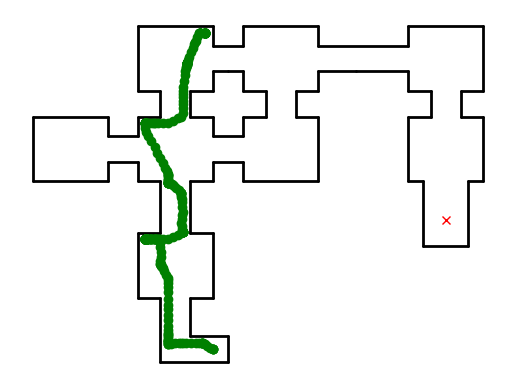

In [20]:
state = env.reset()
sum_reward = 0
n_step = 500
re3_path = [] 

for step in range(n_step):
    action = re3_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      re3_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "default/my_way_home.wad")
                                                       #scenario = "custom/test/dense_new_pattern_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, re3_path)


In [51]:
re3_path_1 = re3_path

In [56]:
re3_path_2 = re3_path

In [61]:
re3_path_3 = re3_path

# Random Agent

In [21]:
import numpy as np 


cumulative reward 479.9807586669922
total steps: 349
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/default/my_way_home.wad
Health Bonus locations: []
Armor location: [(1040.0, -352.0)]
Sector locations: [(160.0, 160.0, -256.0, -96.0), (160.0, 320.0, -96.0, -96.0), (320.0, 320.0, -96.0, -144.0), (320.0, 160.0, -256.0, -256.0), (320.0, 320.0, -208.0, -256.0), (544.0, 496.0, -256.0, -256.0), (544.0, 544.0, -96.0, -144.0), (384.0, 432.0, -96.0, -96.0), (384.0, 384.0, -256.0, -208.0), (384.0, 384.0, -144.0, -96.0), (496.0, 544.0, -96.0, -96.0), (432.0, 384.0, -256.0, -256.0), (544.0, 544.0, -208.0, -256.0), (544.0, 496.0, -32.0, -32.0), (544.0, 544.0, 128.0, 80.0), (384.0, 544.0, 128.0, 128.0), (384.0, 384.0, -32.0, 128.0), (544.0, 544.0, 16.0, -32.0), (432.0, 384.0, -32.0, -32.0), (608.0, 608.0, -256.0, -208.0), (768.0, 608.0, -256.0, -256.0), (768.0, 768.0, -96.0, 

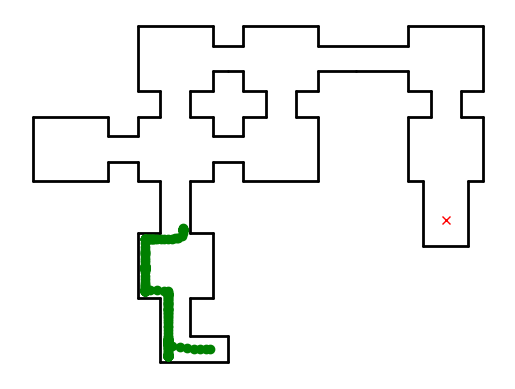

In [23]:
state = env.reset()
sum_reward = 0
n_step = 500
rand_path = [] 

for step in range(n_step):
    action = np.random.randint(3)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      rand_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "default/my_way_home.wad")
                                                       #scenario = "custom/test/dense_new_pattern_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, rand_path)


# All graphs

## All Paths

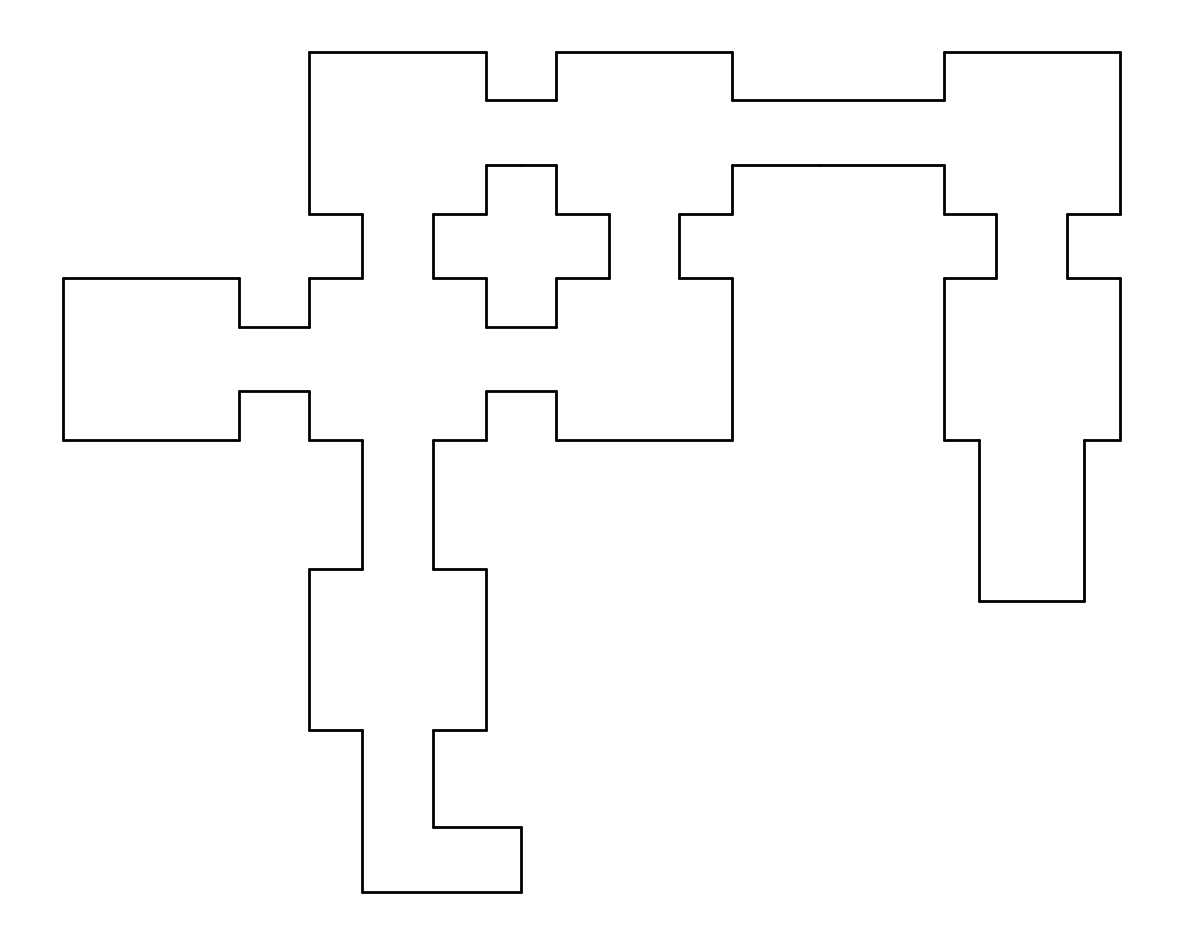

In [24]:
plt.rcParams["figure.figsize"] = (15, 12)

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)

plt.axis("off")
plt.show()

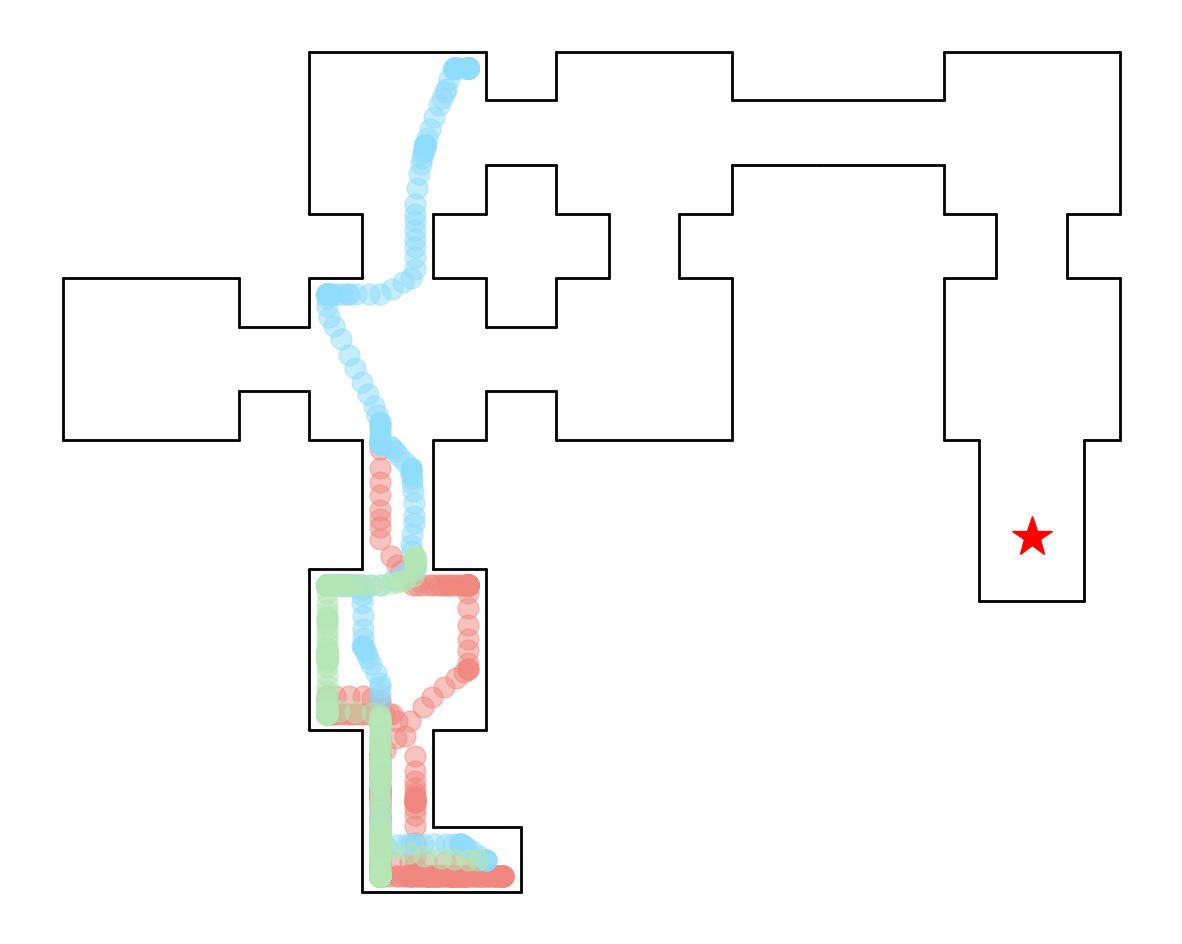

In [26]:
plt.rcParams["figure.figsize"] = (15, 12)

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)


#for pos in icm_path_1:
#    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 15, alpha = 0.5)
#for pos in icm_path_2:
#    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 15, alpha = 0.5)
for pos in icm_path:
    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 15, alpha = 0.5)


for pos in re3_path:
    plt.plot(pos[0], pos[1], color='#8FDCFB', marker='o', markersize=15, alpha = 0.5)

# plot path taken
for pos in rand_path:
    plt.plot(pos[0], pos[1], color='#B5E7B5', marker='o', markersize = 15, alpha = 0.5)    

# plot positions of health bonus and armor:
for pos in health_pos:
    plt.plot(pos[0], pos[1], color='k', marker='X', markersize = 20)
for pos in armor_pos:
    plt.plot(pos[0], pos[1], color='red', marker='*', markersize = 30)

plt.axis("off")
plt.show()


## Average Reward

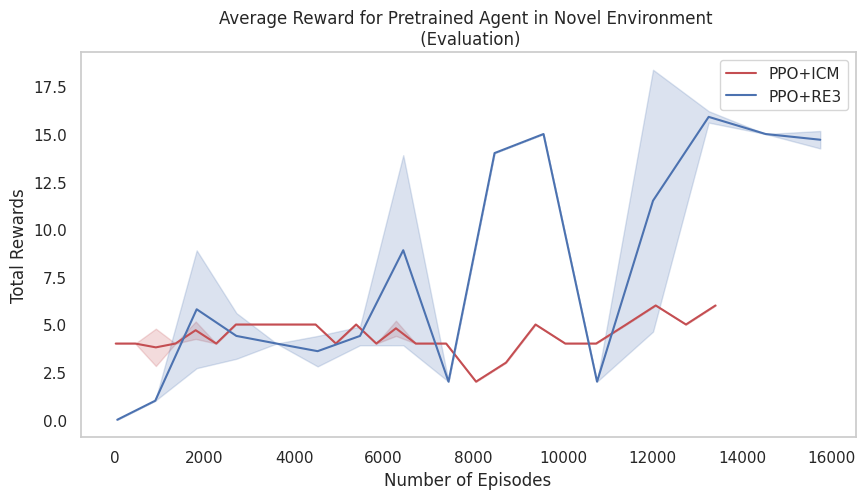

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})
#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='r', alpha=0.2) 
#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 


plt.legend() #title='legend'
plt.xlabel('Number of Episodes') 
plt.ylabel('Total Rewards') 
plt.title("Average Reward for Pretrained Agent in Novel Environment \n (Evaluation)") 
plt.show()


## Average Steps

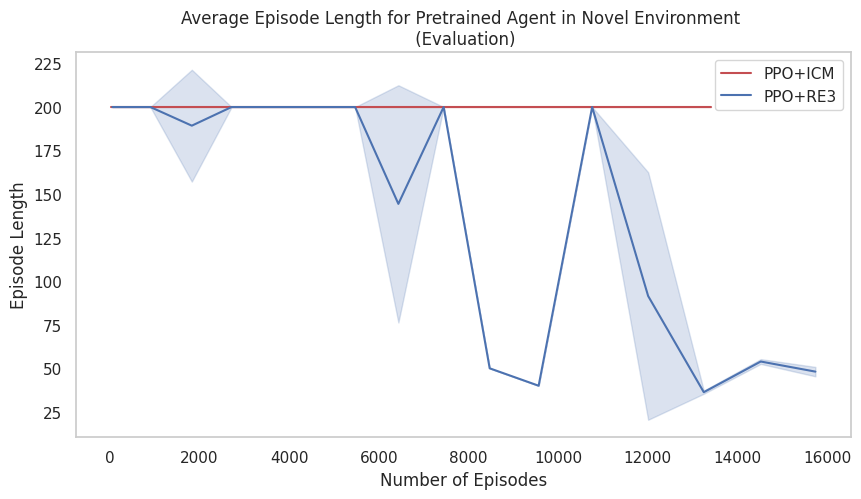

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='r', alpha=0.2) 

#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend()
plt.title("Average Episode Length for Pretrained Agent in Novel Environment \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Episode Length') 
plt.show()

# Save results file

In [ ]:
from pathlib import Path 
root = "/content/drive/MyDrive/GitHub/INM363-Project/results" 
cols = ["episodes", "mean_reward", "std_reward", "mean_steps", "std_steps"]

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ICM

In [ ]:
fname = "/E3_icm_dense_new_pattern.csv"

df_icm = pd.DataFrame(columns = cols)
df_icm["episodes"] = icm_cum_eps
df_icm["mean_reward"] = icm_chkpt_mean_rewards
df_icm["std_reward"] = icm_chkpt_std_rewards
df_icm["mean_steps"] = icm_chkpt_mean_steps
df_icm["std_steps"] = icm_chkpt_std_steps

fpath = Path(root + fname)
df_icm.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_icm.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E3_icm_dense_new_pattern.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,23.0,4.0,0.000000,200.0,0.0
1,459.0,4.0,0.000000,200.0,0.0
2,918.0,3.8,0.979796,200.0,0.0
3,1356.0,4.0,0.000000,200.0,0.0
4,1806.0,4.7,0.458258,200.0,0.0


## RE3

In [ ]:
fname = "/E3_re3_dense_new_pattern.csv"

df_re3 = pd.DataFrame(columns = cols)
df_re3["episodes"] = re3_cum_eps
df_re3["mean_reward"] = re3_chkpt_mean_rewards
df_re3["std_reward"] = re3_chkpt_std_rewards
df_re3["mean_steps"] = re3_chkpt_mean_steps
df_re3["std_steps"] = re3_chkpt_std_steps

fpath = Path(root + fname)
df_re3.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_re3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E3_re3_dense_new_pattern.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,57.0,0.0,0.000000,200.0,0.0
1,905.0,1.0,0.000000,200.0,0.0
2,1829.0,5.8,3.091925,189.3,32.1
3,2715.0,4.4,1.200000,200.0,0.0
4,3611.0,4.0,0.000000,200.0,0.0
